## DeepSeek-OCR Notebook

<img src="https://learnopencv.com/wp-content/uploads/2025/11/DeepSeek-OCR-Paper-Explained.jpg" alt="DeepSeek OCR Paper Explained">

Checkout relevant blog post here: <a href="https://learnopencv.com/what-makes-deepseek-ocr-so-powerful/">DeepSeek-OCR Paper Explained</a>

The only I got Deepseek OCR (with batch image processing) working is using - vLLM nightly build, and `uv` package manager. 
I tried installing through `pip` directly, ended up entangled with multiple dependency issues. 

This notebook is not about DeepSeek-OCR + Transformers. 

I am using an L40S instance from Runpod. The configurations are as follows:
 - Ubuntu 24.04
 - Cuda 12.8
 - GPU 48 GB vRAM
   
Installation steps are as follows:

1. **Create a virtual environment vLLM and activate**

```
uv venv --seed vLLM
source vLLM/bin/activate
```

2. **Install basic packages**
```
uv pip install jupyter ipykernel ipywidgets hf_transfer huggingface_hub Pillow matplotlib PyMuPDF torch-c-dlpack-ext
```
3. **Set up vLLM kernel for jupyter notebook**

```
python -m ipykernel install --user --name vLLM
```
4. **Install vLLM nightly build - Note that I have changed torch CUDA version as per my version**


```
uv pip install -U vllm --pre --extra-index-url https://wheels.vllm.ai/nightly --extra-index-url https://download.pytorch.org/whl/cu128 --index-strategy unsafe-best-match
```

After this you can start working on the notebook by selecting **vLLM** kernel.

### 1.1 Import Dependencies

In [2]:
import time, io, fitz
from PIL import Image
import matplotlib.pyplot as plt
from vllm import LLM, SamplingParams
from vllm.model_executor.models.deepseek_ocr import NGramPerReqLogitsProcessor

### 1.2 Create Model Instance

In [3]:
llm = LLM(
    model="deepseek-ai/DeepSeek-OCR",
    enable_prefix_caching = False,
    mm_processor_cache_gb = 0,
    logits_processors=[NGramPerReqLogitsProcessor]
)

INFO 11-17 12:21:15 [utils.py:253] non-default args: {'enable_prefix_caching': False, 'disable_log_stats': True, 'mm_processor_cache_gb': 0, 'logits_processors': [<class 'vllm.model_executor.models.deepseek_ocr.NGramPerReqLogitsProcessor'>], 'model': 'deepseek-ai/DeepSeek-OCR'}
INFO 11-17 12:21:16 [model.py:631] Resolved architecture: DeepseekOCRForCausalLM
INFO 11-17 12:21:16 [model.py:1745] Using max model len 8192
INFO 11-17 12:21:20 [scheduler.py:216] Chunked prefill is enabled with max_num_batched_tokens=8192.
(EngineCore_DP0 pid=3351) INFO 11-17 12:21:23 [core.py:94] Initializing a V1 LLM engine (v0.11.1rc7.dev237+gd4acf518d) with config: model='deepseek-ai/DeepSeek-OCR', speculative_config=None, tokenizer='deepseek-ai/DeepSeek-OCR', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=8192, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_paral

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


(EngineCore_DP0 pid=3351) INFO 11-17 12:21:33 [default_loader.py:314] Loading weights took 1.25 seconds
(EngineCore_DP0 pid=3351) INFO 11-17 12:21:34 [gpu_model_runner.py:3126] Model loading took 6.2319 GiB memory and 2.291321 seconds
(EngineCore_DP0 pid=3351) INFO 11-17 12:21:34 [gpu_model_runner.py:3876] Encoder cache will be initialized with a budget of 8192 tokens, and profiled with 11 image items of the maximum feature size.
(EngineCore_DP0 pid=3351) INFO 11-17 12:21:39 [backends.py:631] Using cache directory: /root/.cache/vllm/torch_compile_cache/65d70fb6f0/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=3351) INFO 11-17 12:21:39 [backends.py:647] Dynamo bytecode transform time: 3.24 s
(EngineCore_DP0 pid=3351) INFO 11-17 12:21:40 [backends.py:210] Directly load the compiled graph(s) for dynamic shape from the cache, took 0.819 s


(EngineCore_DP0 pid=3351) /workspace/vLLM/lib/python3.12/site-packages/torch/_dynamo/variables/functions.py:1692: UserWarning: Dynamo detected a call to a `functools.lru_cache`-wrapped function. Dynamo ignores the cache wrapper and directly traces the wrapped function. Silent incorrectness is only a *potential* risk, not something we have observed. Enable TORCH_LOGS="+dynamo" for a DEBUG stack trace.
(EngineCore_DP0 pid=3351)   torch._dynamo.utils.warn_once(msg)


(EngineCore_DP0 pid=3351) WARNING 11-17 12:21:41 [fused_moe.py:886] Using default MoE config. Performance might be sub-optimal! Config file not found at ['/workspace/vLLM/lib/python3.12/site-packages/vllm/model_executor/layers/fused_moe/configs/E=64,N=896,device_name=NVIDIA_L40S.json']
(EngineCore_DP0 pid=3351) INFO 11-17 12:21:41 [monitor.py:34] torch.compile takes 4.06 s in total
(EngineCore_DP0 pid=3351) INFO 11-17 12:21:42 [gpu_worker.py:361] Available KV cache memory: 32.12 GiB
(EngineCore_DP0 pid=3351) INFO 11-17 12:21:42 [kv_cache_utils.py:1229] GPU KV cache size: 561,360 tokens
(EngineCore_DP0 pid=3351) INFO 11-17 12:21:42 [kv_cache_utils.py:1234] Maximum concurrency for 8,192 tokens per request: 68.53x


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 51/51 [00:04<00:00, 11.84it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 35/35 [00:01<00:00, 26.65it/s]


(EngineCore_DP0 pid=3351) INFO 11-17 12:21:49 [gpu_model_runner.py:4032] Graph capturing finished in 6 secs, took 0.44 GiB
(EngineCore_DP0 pid=3351) INFO 11-17 12:21:49 [core.py:247] init engine (profile, create kv cache, warmup model) took 14.89 seconds
INFO 11-17 12:21:50 [llm.py:352] Supported tasks: ['generate']


### 1.3 Load PDF File and Convert to Images
I am using two pdf files here:
 - Dataset preparation notebook using Gemini ( Contains notebook code, markdown, links, images and more - All Emglish )
 - Evelta Display Datasheet ( Contains markdowns, images, links and more - in Chinese and English )

Feel free to use your own files as required. Converting to images is mendatory -- as DeepSeek-OCR only accepts images as input. 

In [3]:
!curl -L -o Gemini-Dataset-Prep.pdf https://raw.githubusercontent.com/kXborg/vlms/main/dataset/pdfs/Gemini-Dataset-Prep.pdf
!curl -L -o Evelta-Display.pdf https://raw.githubusercontent.com/kXborg/vlms/main/dataset/pdfs/evelta-7-inch-353-HDW070_008LZ02.pdf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1508k  100 1508k    0     0  4494k      0 --:--:-- --:--:-- --:--:-- 4488k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1122k  100 1122k    0     0  3893k      0 --:--:-- --:--:-- --:--:-- 3911k


In [4]:
def pdf_to_images(pdf_path, dpi=200):
    # Zoom factor: 72 DPI is default, so scale for desired DPI
    zoom = dpi / 72.0
    matrix = fitz.Matrix(zoom, zoom)
    
    doc = fitz.open(pdf_path)
    images = []
    
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        pix = page.get_pixmap(matrix=matrix, alpha=False)
        
        # Convert pixmap to bytes
        img_data = pix.tobytes("png")
        
        # Create PIL Image from bytes
        img = Image.open(io.BytesIO(img_data))
        images.append(img)
    
    doc.close()
    print(f"Found {len(images)} images")
    return images

In [5]:
# Extract Images and Display
gemini_nb = pdf_to_images("Gemini-Dataset-Prep.pdf")

Found 16 images


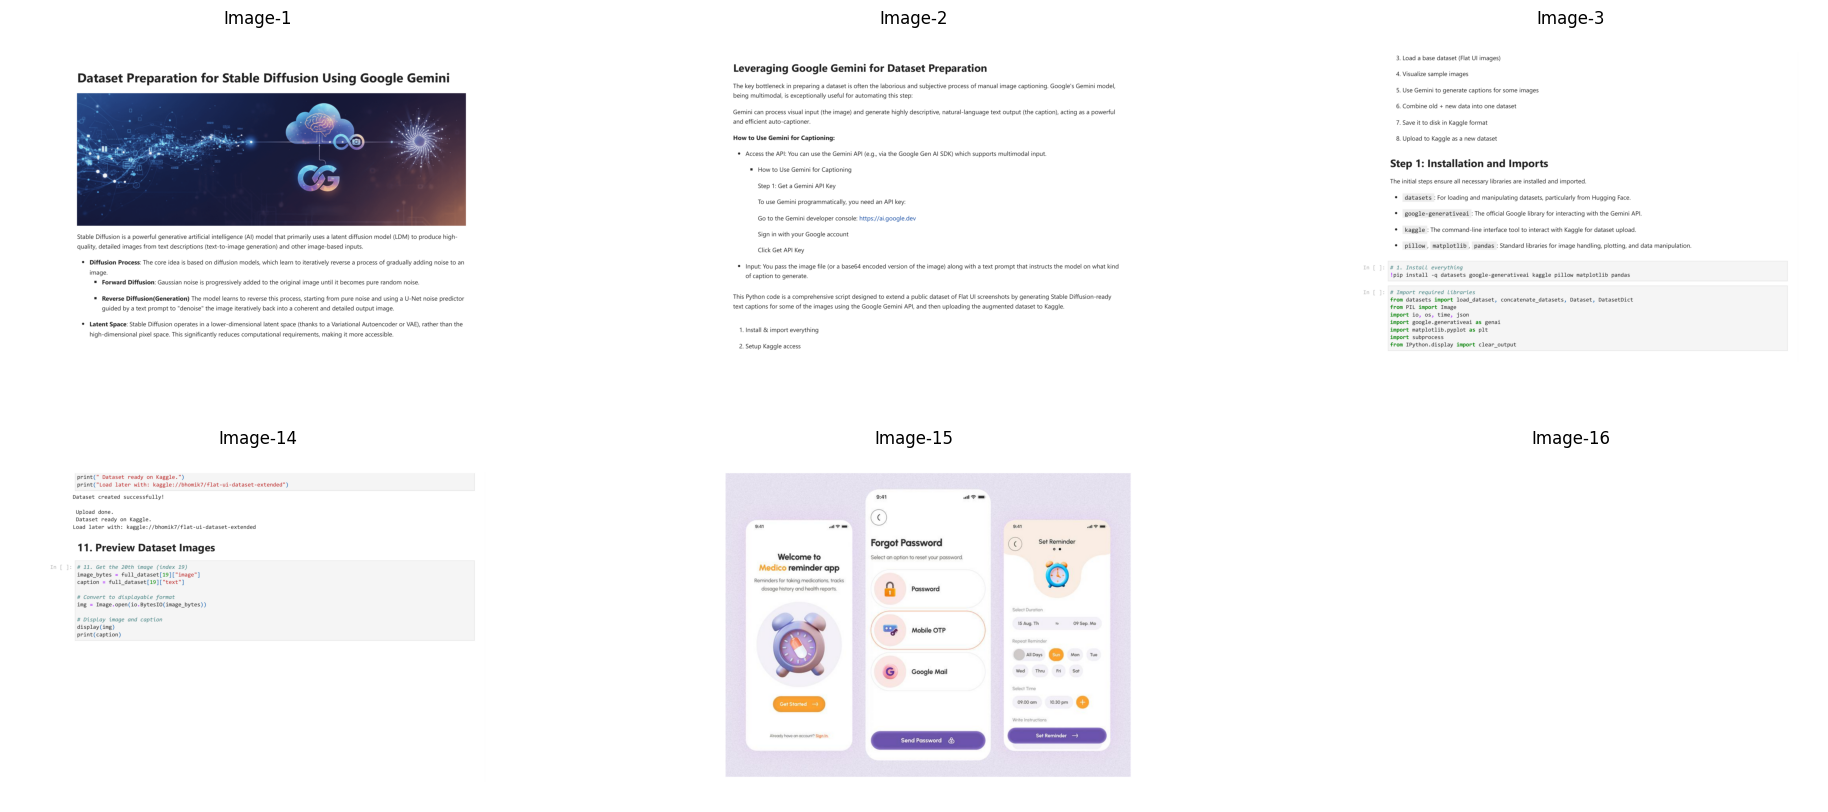

In [7]:
plt.figure(figsize=(24,10))
plt.subplot(231); plt.imshow(gemini_nb[0]); plt.title('Image-1'); plt.axis('off');
plt.subplot(232); plt.imshow(gemini_nb[1]); plt.title('Image-2'); plt.axis('off');
plt.subplot(233); plt.imshow(gemini_nb[2]); plt.title('Image-3'); plt.axis('off');
plt.subplot(234); plt.imshow(gemini_nb[13]); plt.title('Image-14'); plt.axis('off');
plt.subplot(235); plt.imshow(gemini_nb[14]); plt.title('Image-15'); plt.axis('off');
plt.subplot(236); plt.imshow(gemini_nb[15]); plt.title('Image-16'); plt.axis('off');

In [8]:
# Extract Images and Display
evelta_doc = pdf_to_images("Evelta-Display.pdf")

Found 3 images


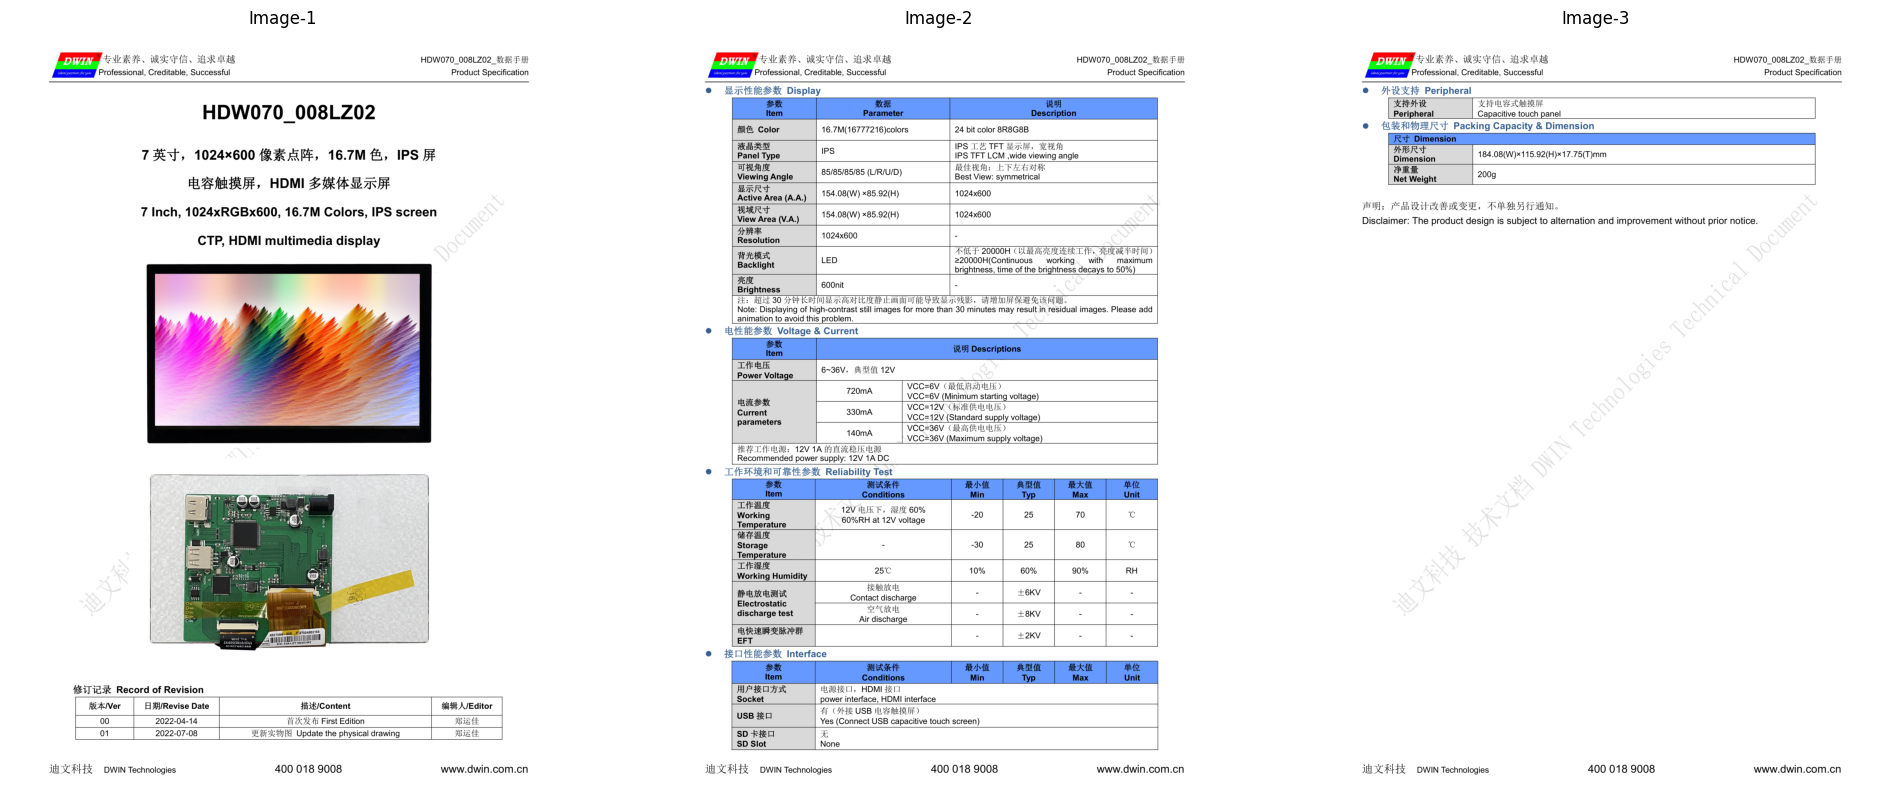

In [9]:
plt.figure(figsize=(24,10))
plt.subplot(131); plt.imshow(evelta_doc[0]); plt.title('Image-1'); plt.axis('off');
plt.subplot(132); plt.imshow(evelta_doc[1]); plt.title('Image-2'); plt.axis('off');
plt.subplot(133); plt.imshow(evelta_doc[2]); plt.title('Image-3'); plt.axis('off');

### Function to Run Inference Call

Few things to note below in `samplingParams`:
 - `temperature=0.0` : Greedy decoding, always selects next most probable next token (no randomness here)
 - `extra_args` : It is to avoid repeatation of hellucinated outputs. Requires `NGramPerReqLogitsProcessor`, a custom vLLM extension for n-gram repetition penalties.

We will talk more about `NGramPerReqLogitsProcessor` more in the [DeepSeek-OCR Explanation Blog Post](https://learnopencv.com/what-makes-deepseek-ocr-so-powerful/). By the way, I contrubuted a little, sponsoring vLLM for their amazing contributions - pagedAttention, prefix caching, continuous batching and more. Do sponsor vLLM if you liked their work.

[![Sponsoring vLLM kXborg](https://learnopencv.com/wp-content/uploads/2025/11/vLLM-sponsor-kXborg.png)](https://github.com/kXborg)

Inside `extra_args`:
 - `ngram_size=30` : Scans the last 30 tokens for repeating sequences; penalizes if an n-gram (substring of tokens) repeats too frequently.
 - `window_size=90` : Sliding window over the last 90 tokens for global repetition checks broader context than `ngram_size`.
 - `whitelist_token_ids={128821, 128822}` : Exempts specific token IDs from penalties, treats them as "safe" even if repeated. These are DeepSeek's ChatMl boundary token.

**How Repetition Works?**
1. Tracks recent tokens in the `window_size`.
2. For each candidate next token, checks if it forms a penalized n-gram.
3. Lowers logits (probabilities) for repeats, unless whitelisted.

Result: Cleaner, non-looping outputs for repetitive structures like invoices or charts.
Trade-off: Too aggressive? Outputs get truncated. Tune via `ngram_size` (smaller = less penalty).

In [26]:
# Logits processor
sampling_param_1 = SamplingParams(
        temperature=0.0,
        max_tokens=8192,
        extra_args=dict(
            ngram_size=30,
            window_size=90,
            whitelist_token_ids={128821, 128822},
        ),
        skip_special_tokens=False,
    )

In [27]:
def run_inference(images, base_prompt, llm, logits_proc=sampling_param_1):
    model_input = []
    for image in images:
        model_input.append({
            "prompt": base_prompt,
            "multi_modal_data": {"image": image}
        })

    sampling_param = logits_proc

    t1 = time.time()
    model_outputs = llm.generate(model_input, sampling_param)
    t2 = time.time()

    print(f"Time taken to process {len(images)} image(s): {round(t2 - t1, 2)}s")

    return model_outputs

### Test Example 1

In [21]:
base_prompt = "<image>\nFree OCR."
results_1 = run_inference(evelta_doc, base_prompt, llm)

Adding requests:   0%|          | 0/3 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/3 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Time taken to process 3 image(s): 3.51s


In [22]:
# Display Texts
for output in results_1:
    print(output.outputs[0].text)

HDW070_008LZ02

7英寸，1024×600像素点阵，16.7M色，IPS屏
电容触摸屏，HDMI多媒体显示屏

7 Inch, 1024xRGBx600, 16.7M Colors, IPS screen
CTP, HDMI multimedia display

修订记录 Record of Revision

| 版本/Ver | 日期/Revise Date | 描述/Content | 编辑人/Editor |
|---------|-----------------|--------------|---------------|
| 00      | 2022-04-14      | 首次发布 First Edition | 郑运佳 |
| 01      | 2022-07-08      | 更新实物图 Update the physical drawing | 郑运佳 |

迪文科技 DWIN Technologies 400 018 9008 www.dwin.com.cn
### 显示性能参数 Display

| 参数 Item | 数据 Parameter | 说明 Description |
|----------|---------------|----------------|
| 颜色 Color | 16.7M(16777216)colors | 24 bit color 8R8G8B |
| 液晶类型 Panel Type | IPS | IPS 工艺 TFT 显示屏，宽视角 IPS TFT LCM, wide viewing angle |
| 可视角度 Viewing Angle | 85/85/85/85 (L/R/U/D) | 最佳视角：上下左右对称 Best View: symmetrical |
| 显示尺寸 Active Area (A.A.) | 154.08(W) × 85.92(H) | 1024x600 |
| 视域尺寸 View Area (V.A.) | 154.08(W) × 85.92(H) | 1024x600 |
| 分辨率 Resolution | 1024x600 | - |
| 背光模式 Backlight | LED | 不低于 20000H（以最高亮度连续工作，亮度减半

### Test Example 2

In [32]:
base_prompt = "<image>\nFree OCR."
# The last image is blank, let's send first 15 images only for processing
results_2 = run_inference(gemini_nb[:-1], base_prompt, llm)

Adding requests:   0%|          | 0/15 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/15 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Time taken to process 15 image(s): 5.59s


In [33]:
print(results_2[13].outputs[0].text)

print(" Dataset ready on Kaggle.")
print("Load later with: kaggle://bhomik7/flat-ui-dataset-extended")

Dataset created successfully!

Upload done.
Dataset ready on Kaggle.
Load later with: kaggle://bhomik7/flat-ui-dataset-extended

11. Preview Dataset Images

In [ ]:
# 11. Get the 20th image (index 19)
image_bytes = full_dataset[19]["image"]
caption = full_dataset[19]["text"]

# Convert to displayable format
img = Image.open(io.ByteIO(image_bytes))

# Display image and caption
display(img)
print(caption)


### Test Example 3: What happens if we send a blank image?

In [38]:
# I am sending last 2 images (as I created the script to take care of mutiple images, stupidly not caring much about single input). Will fix it later. Let's just roll with it for now.
results_3 = run_inference(gemini_nb[-2:], base_prompt, llm)

Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Time taken to process 2 image(s): 28.78s


In [40]:
print(results_3[1].outputs[0].text)

<table><tr><td>Category</td><td>Value</td></tr><tr><td>Total</td><td>$1,000</td></tr><tr><td>Total</td><td>$1,000</td></tr><tr><td>Total</td><td>$1,000</td></tr><tr><td>Total</td><td>1,000</td></tr><tr><td>Total</td><td>1,000</td></tr><tr><td>Total</td><td>1,000</td></tr><tr><td>Total</td><td>2,000</td></tr><tr><td>Total</td><td>2,000</td></tr><tr><td>Total</td><td>2,000</td></tr><tr><td>Total</td><td>3,000</td></tr><tr><td>Total</td><td>3,000</td></tr><tr><td>Total</td><td>3,000</td></tr><tr><td>Total</td><td>4,000</td></tr><tr><td>Total</td><td>4,000</td></tr><tr><td>Total</td><td>4,000</td></tr><tr><td>Total</td><td>5,000</td></tr><tr><td>Total</td><td>5,000</td></tr><tr><td>Total</td><td>5,000</td></tr><tr><td>Total</td><td>6,000</td></tr><tr><td>Total</td><td>6,000</td></tr><tr><td>Total</td><td>6,000</td></tr><tr><td>Total</td><td>7,000</td></tr><tr><td>Total</td><td>7,000</td></tr><tr><td>Total</td><td>7,000</td></tr><tr><td>Total</td><td>8,000</td></tr><tr><td>Total</td><td>8,0

### Fail Case Study
The inference call worked great with all 15 images, except for the last blank image.

The reasons could be:
 - The model sees a very repetitive layout and starts hallucinating a never-ending table of totals.
 - The n-gram detector only looks at the last `30 tokens` inside a `90-token window`. That’s way too small to catch the pattern “<tr><td>Total</td><td>XXX,000</td></tr> repeating every ~12 tokens”.

**What we will do next?**

Make the logits processor much more strict. 
 - `ngram_size=8`
 - `window_size=256`

In [41]:
# Logits processor
sampling_param_2 = SamplingParams(
        temperature=0.0,
        max_tokens=8192,
        extra_args=dict(
            ngram_size=8,
            window_size=256,
            whitelist_token_ids={128821, 128822},
        ),
        skip_special_tokens=False,
    )

In [42]:
results_4 = run_inference(gemini_nb[-2:], base_prompt, llm, logits_proc=sampling_param_2)

Adding requests:   0%|          | 0/2 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/2 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Time taken to process 2 image(s): 1.08s


In [43]:
print(results_4[1].outputs[0].text)

<table><tr><td>Category</td><td>Value</td></tr><tr><td>Total</td><td>$1,000</td></tr><tr><td>Total</td><td>1,000</td></tr><tr><td>$1,000</td><td>1,000</td></tr></table>
